In [1]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9], preprocess=True)
systems = set([x['system'] for x in data])
edit_types = set(data[0]['annotations'].keys())

# TODO: trivial edits on substitutions aren't being processed correctly

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_anton.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_ayush.json', '../annotated/batch_9_kelly.json', '../annotated/batch_9_rachel.json', '../annotated/

In [2]:
# Find an example sentence
found = []
for sent in data:
    if 'GPT-3-few-shot' not in sent['system']:
        continue 

    errors = [a for a in sent['processed_annotations'] if a['error_type'] is not None]

    # Aim for 2-4 errors
    if len(errors) < 2:
        continue

    # Exclude longer sentences
    if len(sent['original']) > 200:
        continue

    print(get_sent_info(sent))
    found += [sent]

# Our Winner is: anton - Batch 7, HIT 23 (ID 170)
example = found[2]
print(get_sent_info(found[2]))

print(f"Average score: {avg([avg(x.values()) for x in example['da_scores']])}")

vinayak - Batch 7, HIT 2 (ID 95)
vishnesh - Batch 7, HIT 18 (ID 106)
anton - Batch 7, HIT 23 (ID 111)
vishnesh - Batch 7, HIT 31 (ID 111)
vishnesh - Batch 7, HIT 48 (ID 156)
rachel - Batch 7, HIT 27 (ID 187)
vishnesh - Batch 8, HIT 4 (ID 187)
vishnesh - Batch 8, HIT 10 (ID 192)
vishnesh - Batch 8, HIT 23 (ID 198)
rachel - Batch 7, HIT 44 (ID 203)
vishnesh - Batch 8, HIT 46 (ID 217)
anton - Batch 8, HIT 28 (ID 230)
vishnesh - Batch 8, HIT 28 (ID 258)
rachel - Batch 8, HIT 2 (ID 275)
vinayak - Batch 9, HIT 8 (ID 393)
vishnesh - Batch 9, HIT 4 (ID 393)
anton - Batch 7, HIT 23 (ID 111)
Average score: 97.44


In [3]:
get_comments(data)

ANTON - HIT 66: 

ANTON - HIT 135: I am calling exactly a bad deletion because I think it is necessary for these sentences. It shows that Russia is deliberately targeting enough infrastructure to halt ukrainian energy production. It show's Russia's intent is calculated and cruel. 

AYUSH - HIT 159: sentence was copy pasted :/

VISHNESH - HIT 199: Marked most successful as a bad substitution because I think there can be multiple metrics to judge a movie's success.

VINAYAK - HIT 227: I wasn't exactly sure if the England team here could be singular here, but I believe it can.

VISHNESH - HIT 256: I was not sure how to mark the error of "The book" being used at the start of the sentence without being introduced previously so I marked it as a fluency error.

AYUSH - HIT 265: the sentence is the same

AYUSH - HIT 266: sentence is really long to parse, probably gonna miss some annotations for this sentence

AYUSH - HIT 269: Missing a split

VINAYAK - HIT 269: Missing a split on Hit 17?


VIS

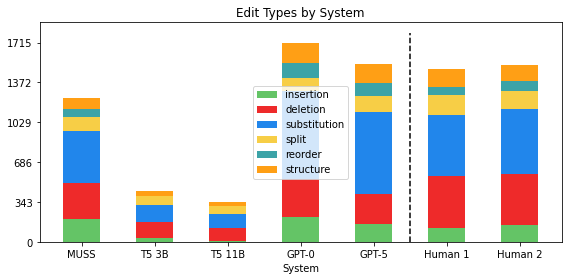

In [4]:
edit_type_by_system(data)

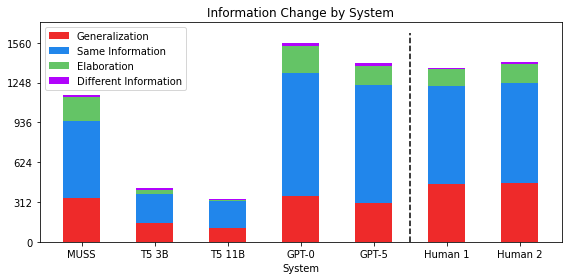

In [5]:
system_by_information_change(data)

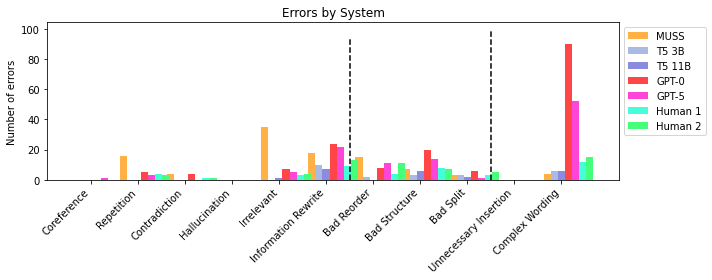

In [6]:
errors_by_system(data)

In [7]:
sankey_combined(data)

In [8]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

GPT-5 	 10.08
T5 3B 	 1.7
GPT-0 	 8.91
MUSS 	 4.42
Human 1 	 11.13
T5 11B 	 0.87
Human 2 	 11.31


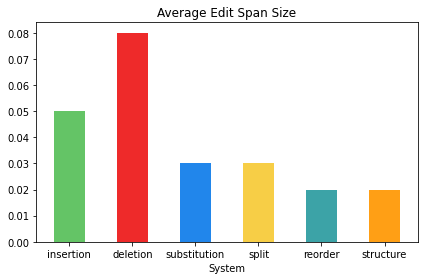

In [9]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

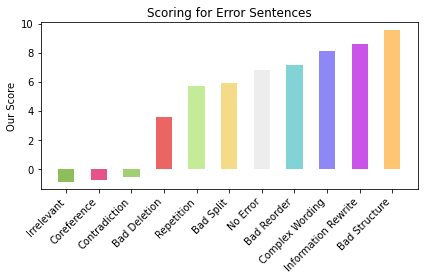

In [10]:
class Tmp(Enum):
    NO_ERROR = 'No Error'

error_segmentation = {}
for error in Error:
    error_segmentation[error] = [sent for sent in data if any([ann['error_type'] == error for ann in sent['processed_annotations']])]
error_segmentation[Tmp.NO_ERROR] = [sent for sent in data if not any([ann['error_type'] == error for ann in sent['processed_annotations']])]

pts = []
pts += [(error, avg([s['score'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(6, 4))

cust_mapping = color_mapping
cust_mapping[Tmp.NO_ERROR] = '#ededed'

ax.bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[cust_mapping[label] for label in [p[0] for p in pts]])
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Our Score')
ax.set_title('Scoring for Error Sentences')
plt.show()

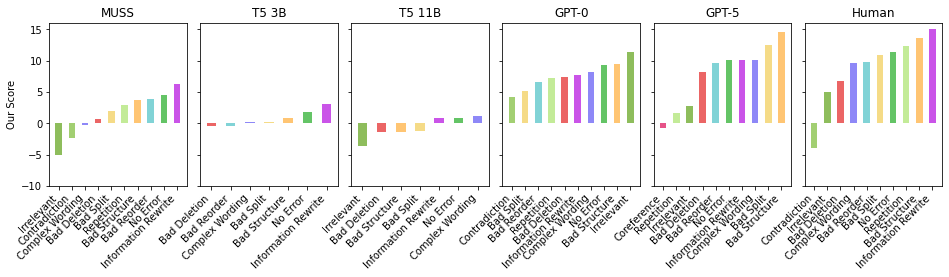

In [11]:
class Tmp(Enum):
    NO_ERROR = 'No Error'

cust_systems = [s for s in systems if 'Human' not in s] + ['aggregated/human']

fig, ax = plt.subplots(1, len(cust_systems), figsize=(16, 3), sharey=True, gridspec_kw = {'wspace': 0.1, 'hspace':0})
for i, system in enumerate([s for s in all_system_labels if s in cust_systems]):
    selected = [sent for sent in data if sent['system'] == system]
    if system == 'aggregated/human':
        selected = [sent for sent in data if 'Human' in sent['system']]

    error_segmentation = {}
    for error in Error:
        error_segmentation[error] = [sent for sent in selected if any([ann['error_type'] == error for ann in sent['processed_annotations']])]
    error_segmentation[Tmp.NO_ERROR] = [sent for sent in selected if not any([ann['error_type'] == error for ann in sent['processed_annotations']])]

    pts = []
    pts += [(error, avg([s['score'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
    pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])

    cust_mapping = color_mapping
    cust_mapping[Tmp.NO_ERROR] = '#64C466'

    ax[i].bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[cust_mapping[label] for label in [p[0] for p in pts]])
    ax[i].set_title(system_name_mapping[system])
    # ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(-10, 16, 5))

for tick in [i for j in [x.get_xticklabels() for x in ax] for i in j]:
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')

# fig.suptitle('Avg. Error Sent Scores')
ax[0].set_ylabel('Our Score')
# plt.legend([p[0].value for p in pts], loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=3)
out_filename = f'img/error-scores.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

In [12]:
def get_annotations_by_edit_family(data, edit_type):
    information_change = None
    if edit_type == 'paraphrase':
        family = Family.LEXICAL
        edit_type = 'substitution'
    elif edit_type == 'split' or edit_type == 'structure' or edit_type == 'reorder':
        family = Family.SYNTAX
    elif edit_type == 'elaboration' or edit_type == 'generalization':
        family = Family.CONTENT
        if edit_type == 'elaboration':
            information_change = Information.MORE
        elif edit_type == 'generalization':
            information_change = Information.LESS
    else:
        raise ValueError(f'Edit type not supported for this operation: {edit_type}')

    anns = [ann for sent in data for ann in sent['processed_annotations']]
    selected = [ann for ann in anns if ann['family'] == family and ann['edit_type'] == edit_type]
    if edit_type == 'elaboration' or edit_type == 'generalization':
        selected = [ann for ann in anns if ann['information_impact'] == information_change]

    return selected

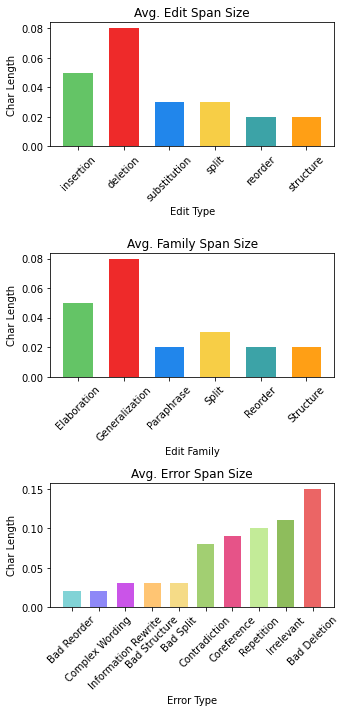

In [13]:
families = [
    'elaboration',
    'generalization',
    'paraphrase',
    'split',
    'reorder',
    'structure',
]

class Tmp(Enum):
    NO_ERROR = 'No Error'

width = 0.65
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
fig, ax = plt.subplots(3, 1, figsize=(5, 10))

edit_size = [avg([x['size'] for x in annotations if x['edit_type'] == edit_type]) for edit_type in edit_type_labels]
ax[0].bar(edit_type_labels, edit_size, width, color=[color_mapping[label] for label in edit_type_labels])

fam_size = [avg([x['size'] for x in get_annotations_by_edit_family(data, family)]) for family in families]
ax[1].bar([x.capitalize() for x in families], fam_size, width, color=[color_mapping[label] for label in families])

anns = [ann for sent in data for ann in sent['processed_annotations']]
error_segmentation = {}
for error in Error:
    error_segmentation[error] = [a for a in anns if error == a['error_type']]
error_segmentation[Tmp.NO_ERROR] = [a for a in anns if error == None]
pts = []
pts += [(error, avg([s['size'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])
ax[2].bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[color_mapping[label] for label in [p[0] for p in pts]])

ax[0].set_xlabel('Edit Type')
ax[1].set_xlabel('Edit Family')
ax[2].set_xlabel('Error Type')

ax[0].set_ylabel('Char Length')
ax[1].set_ylabel('Char Length')
ax[2].set_ylabel('Char Length')

ax[0].set_title('Avg. Edit Span Size')
ax[1].set_title('Avg. Family Span Size')
ax[2].set_title('Avg. Error Span Size')

for tick in ax[0].get_xticklabels() + ax[1].get_xticklabels() + ax[2].get_xticklabels():
    tick.set_rotation(45)
plt.show()

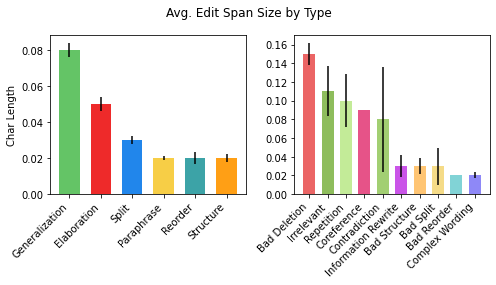

In [14]:
families = [
    'elaboration',
    'generalization',
    'paraphrase',
    'split',
    'reorder',
    'structure',
]

class Tmp(Enum):
    NO_ERROR = 'No Error'

import scipy.stats as st
def ci(int_data):
    y1, y2 = st.t.interval(alpha=0.95, df=len(int_data)-1, loc=np.mean(int_data), scale=st.sem(int_data)) 
    # If it's too big, we just won't even return it
    if y1 <= 0.01 or math.isnan(y1):
        return 0
    return (y2-y1) / 2

width = 0.65
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
fig, ax = plt.subplots(1, 2, figsize=(7, 4))

fam_size = [(family, avg([x['size'] for x in get_annotations_by_edit_family(data, family)]), ci([x['size'] for x in get_annotations_by_edit_family(data, family)])) for family in families]
pts = sorted([p for p in fam_size if p[1] != 0], key=lambda x: x[1], reverse=True)
ax[0].bar([p[0].capitalize() for p in pts], [p[1] for p in pts], width, yerr=[p[2] for p in pts], color=[color_mapping[label] for label in families])

anns = [ann for sent in data for ann in sent['processed_annotations']]
error_segmentation = {}
for error in Error:
    error_segmentation[error] = [a for a in anns if error == a['error_type']]
error_segmentation[Tmp.NO_ERROR] = [a for a in anns if error == None]
pts = [(error, avg([s['size'] for s in error_segmentation[error]]), ci([s['size'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1], reverse=True)
ax[1].bar([p[0].value for p in pts], [p[1] for p in pts], width, yerr=[p[2] for p in pts], color=[color_mapping[label] for label in [p[0] for p in pts]])

# ax[0].set_xlabel('Edit Family')
# ax[1].set_xlabel('Error Type')

ax[0].set_ylabel('Char Length')
ax[1].set_ylabel('')

plt.suptitle('Avg. Edit Span Size by Type')
# ax[1].set_title('Avg. Error Span Size')

ax[0].set_yticks(np.arange(0, 0.085, 0.02))
ax[1].set_yticks(np.arange(0, 0.17, 0.02))

for tick in ax[0].get_xticklabels() + ax[1].get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')

out_filename = f'img/edit-sizes.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json']

Found users: {'ayush', 'vinayak', 'kelly', 'rachel', 'anton', 'vishnesh'}

rachel - Batch 4, HIT 5 (ID 124) has 1 split edits but 0 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 4, HIT 15 (ID 134) has 1 split edits but 0 annotations. Likely a missing annotation. Skipping edit type...
When processing sentence: rachel - Batch 4, HIT 5 (ID 124). Caught error on: Could not process edit: {'type': 'deletion', 'id': 5, 'original_span': [(95, 98)], 'simplified_span': None, 'annotation': None}. Skipping...


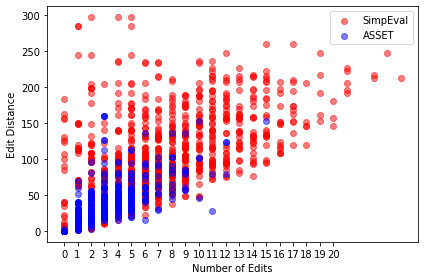

In [15]:
asset = load_data('../annotated', batch_num=[1, 2, 3, 4], preprocess=True)

pts = []
for sent in data:
    pts += [(
        len(sent['processed_annotations']),
        edit_dist(sent['original'], sent['simplified'])
    )]
plt.scatter([p[0] for p in pts], [p[1] for p in pts], color='red', label='SimpEval', alpha=0.5)

pts = []
for sent in asset:
    pts += [(
        len(sent['processed_annotations']),
        edit_dist(sent['original'], sent['simplified'])
    )]
plt.scatter([p[0] for p in pts], [p[1] for p in pts], color='blue', label='ASSET', alpha=0.5)

plt.xticks(np.arange(0, 21, 1))

# plt.title('Edit Distance vs. Number of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Edit Distance')
plt.legend()
out_filename = f'img/edit-distance-num-edits.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

In [16]:
for sent in data:
    sent['ed'] = edit_dist(sent['original'], sent['simplified'])

In [17]:
for sent in asset:
    sent['ed'] = edit_dist(sent['original'], sent['simplified'])

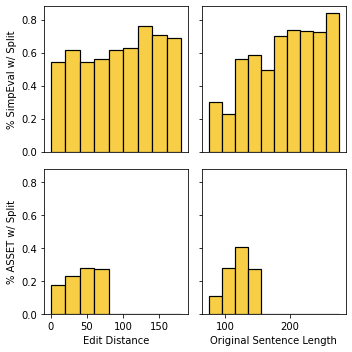

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5), sharey=True)

# If a bucket has less than this value, we don't include it
representative_sample_size = 15

for k, dataset in enumerate([data, asset]):
    bucket_size = 20
    start_amt = 0
    end_amt = 205
    pts = []
    for i in range((end_amt - start_amt) // bucket_size):
        start_size = start_amt + i * bucket_size
        end_size = start_amt + (i + 1) * bucket_size

        selected = [s for s in dataset if start_size <= s['ed'] < end_size]

        splits = 0
        for sent in selected:
            if len([a for a in sent['edits'] if a['type'] == 'split']) >= 1:
                splits += 1
        if len(selected) > representative_sample_size:
            pts += [(start_size, splits / len(selected))]
        else:
            pts += [(start_size, 0)]
    ax[k, 0].hist([p[0] for p in pts][:-1], [p[0] for p in pts], weights=[p[1] for p in pts[1:]], color=color_mapping['split'], edgecolor='black', linewidth=1.2)

    bucket_size = 20
    start_amt = 75
    end_amt = 300
    pts = []
    for i in range((end_amt - start_amt) // bucket_size):
        start_size = start_amt + i * bucket_size
        end_size = start_amt + (i + 1) * bucket_size

        selected = [s for s in dataset if start_size <= len(s['simplified']) < end_size]

        splits = 0
        for sent in selected:
            if len([a for a in sent['edits'] if a['type'] == 'split']) >= 1:
                splits += 1
        
        if len(selected) > representative_sample_size:
            pts += [(start_size, splits / len(selected))]
        else:
            pts += [(start_size, 0)]
    ax[k, 1].hist([p[0] for p in pts][:-1], [p[0] for p in pts], weights=[p[1] for p in pts[1:]], color=color_mapping['split'], edgecolor='black', linewidth=1.2)

# fig.suptitle('Proportion of Sentences with a Split Edit')
ax[0, 0].set_xticks([])
ax[0, 1].set_xticks([])
ax[1, 0].set_xlabel('Edit Distance')
ax[1, 1].set_xlabel('Original Sentence Length')
ax[0, 0].set_ylabel('% SimpEval w/ Split')
ax[1, 0].set_ylabel('% ASSET w/ Split')

out_filename = f'img/split-edit-sizes.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

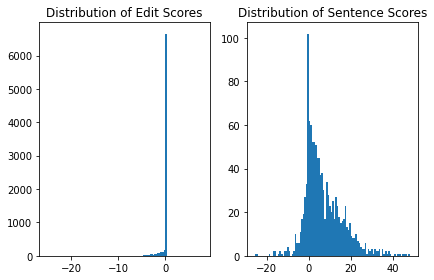

In [19]:
# Show the distribution of edit and sentence scores
score_distribution(data)

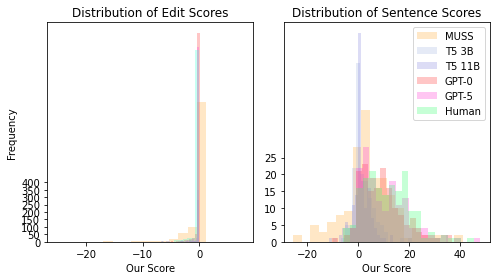

In [20]:
import random

n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(7, 4))

for system in [s for s in all_system_labels if s in systems and 'Human' not in s]:
    annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if sent['system'] == system] for x in y], key=lambda x: x['score'])
    axs[0].hist([x['score'] for x in annotations], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])
    axs[1].hist([x['score'] for x in data if x['system'] == system], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])

# Only human annotations
annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if 'Human' in sent['system']] for x in y], key=lambda x: x['score'])
edit_scores, sent_scores = [x['score'] for x in annotations], [x['score'] for x in data if 'Human' in x['system']]
axs[0].hist(random.sample(edit_scores, int(len(edit_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 1 Writing'])
axs[1].hist(random.sample(sent_scores, int(len(sent_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])

axs[0].set_yticks(np.arange(0, 401, 50))
axs[1].set_yticks(np.arange(0, 26, 5))

axs[0].set_title("Distribution of Edit Scores")
axs[1].set_title("Distribution of Sentence Scores")

axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Our Score")
axs[1].set_xlabel("Our Score")

axs[1].legend()

out_filename = f'img/score-distributions.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()


In [21]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
vishnesh - Batch 9, HIT 10 (ID 370) - 47.91326411618305
vinayak - Batch 5, HIT 33 (ID 68) - 46.413785547944784
vishnesh - Batch 6, HIT 32 (ID 78) - 45.33118134054537
vinayak - Batch 6, HIT 16 (ID 27) - 44.49183097534004
anton - Batch 8, HIT 45 (ID 247) - 43.220743635078165

Lowest scoring:
rachel - Batch 7, HIT 9 (ID 102) - -25.677976439865404
anton - Batch 7, HIT 13 (ID 102) - -24.38384429790904
anton - Batch 5, HIT 29 (ID 16) - -18.858700167805132
anton - Batch 6, HIT 16 (ID 69) - -16.69249648750433
anton - Batch 7, HIT 25 (ID 113) - -16.24140076336377


In [22]:
# Get setences with a score of 0
zeros = zero_scoring_sents(data)

anton - Batch 7, HIT 3 (ID 92)
kelly - Batch 7, HIT 3 (ID 92)
vinayak - Batch 7, HIT 5 (ID 92)
kelly - Batch 7, HIT 35 (ID 159)
vishnesh - Batch 7, HIT 49 (ID 159)


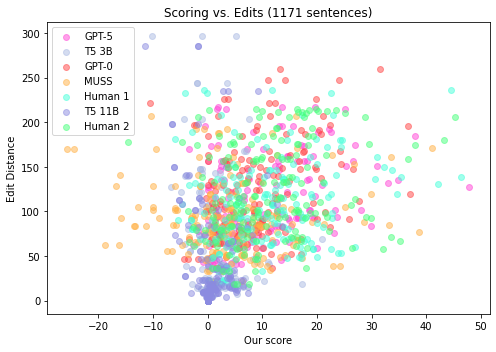

In [23]:
# average_scores: Averages our scores before plotting
edit_length(data, systems, simpeval=False, average_scores=False)

In [24]:
# Get sentences with at least 1 structure change from 1 annotator
ids = sorted(list(set([sent['id'] for sent in data if 'structure' in [x['type'] for x in sent['edits']]])))
print(f'Sentences with at least 1 structure change: {len(ids)} / {len(data)}')

Sentences with at least 1 structure change: 289 / 1171


rachel - Batch 5, HIT 10 (ID 4)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In Marriages and Infidelities, Oates uses many short stories and novellas by earlier writers. || She uses their titles or their themes, and changes them to fit her own ideas of what is important.



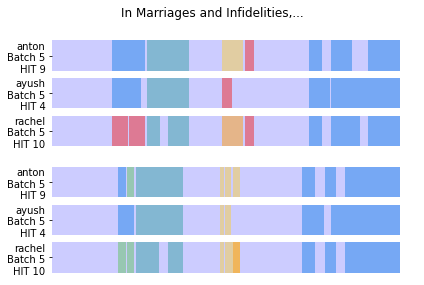

In [25]:
# Display a sentence with a structure change
id_ = 4
sents = [sent for sent in data if sent['id'] == ids[id_]]
print_changes(sents)
draw_agreement(sents)

In [26]:
for system in systems:
    aloe, aloe_no_del, perc_error = error_rate([sent for sent in data if system == sent['system']])
    print(f'''
    --- {system} ---
    Sentences with at least 1 error: {aloe}
    Sentences with at least 1 error excluding bad deletion: {aloe_no_del}
    Percentage of error edits: {perc_error}
    ''')


    --- new-wiki-1/GPT-3-few-shot ---
    Sentences with at least 1 error: 0.5806451612903226
    Sentences with at least 1 error excluding bad deletion: 0.4258064516129032
    Percentage of error edits: 0.10897435897435898
    

    --- new-wiki-1/T5-3B ---
    Sentences with at least 1 error: 0.42073170731707316
    Sentences with at least 1 error excluding bad deletion: 0.1402439024390244
    Percentage of error edits: 0.21479713603818615
    

    --- new-wiki-1/GPT-3-zero-shot ---
    Sentences with at least 1 error: 0.6540880503144654
    Sentences with at least 1 error excluding bad deletion: 0.5283018867924528
    Percentage of error edits: 0.14166666666666666
    

    --- new-wiki-1/Muss ---
    Sentences with at least 1 error: 0.7657142857142857
    Sentences with at least 1 error excluding bad deletion: 0.4857142857142857
    Percentage of error edits: 0.22029488291413704
    

    --- new-wiki-1/Human 1 Writing ---
    Sentences with at least 1 error: 0.4971751412429379
 

In [27]:
# What % content edits are elaboration vs generalization

# Graphs each system with 6 columns each. Each column is a different quality edit. 
# This takes the average rating of each edit

In [28]:
# avg_edit_ratings(data)

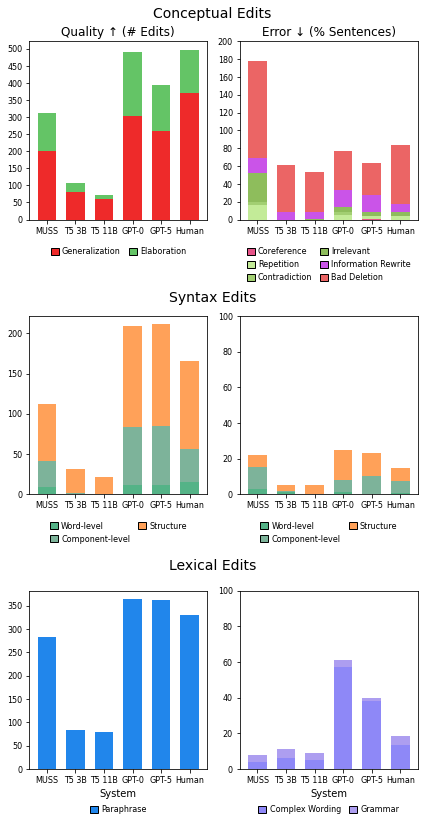

In [29]:
# Older version which combines graphs side-by-side
# edits_by_family(data)

# edits_by_family(data, Family.CONTENT)
# edits_by_family(data, Family.SYNTAX)
# edits_by_family(data, Family.LEXICAL)

edits_by_family_separated(data, savefig=True)
edits_by_family_separated(data)

In [30]:
get_edits_by_family(data, Family.CONTENT, errors_by_sent=True)

{'new-wiki-1/GPT-3-few-shot': {'quality': {<Information.LESS: 'Generalization'>: 259,
   <Information.SAME: 'Same Information'>: 0,
   <Information.MORE: 'Elaboration'>: 136,
   <Information.DIFFERENT: 'Different Information'>: 0},
  'error': {<Error.COREFERENCE: 'Coreference'>: 1,
   <Error.REPETITION: 'Repetition'>: 3,
   <Error.CONTRADICTION: 'Contradiction'>: 0,
   <Error.HALLUCINATION: 'Hallucination'>: 0,
   <Error.IRRELEVANT: 'Irrelevant'>: 5,
   <Error.INFORMATION_REWRITE: 'Information Rewrite'>: 18,
   <Error.BAD_DELETION: 'Bad Deletion'>: 36,
   <Error.BAD_REORDER: 'Bad Reorder'>: 0,
   <Error.BAD_STRUCTURE: 'Bad Structure'>: 0,
   <Error.BAD_SPLIT: 'Bad Split'>: 0,
   <Error.UNNECESSARY_INSERTION: 'Unnecessary Insertion'>: 0,
   <Error.COMPLEX_WORDING: 'Complex Wording'>: 0}},
 'new-wiki-1/T5-3B': {'quality': {<Information.LESS: 'Generalization'>: 80,
   <Information.SAME: 'Same Information'>: 0,
   <Information.MORE: 'Elaboration'>: 27,
   <Information.DIFFERENT: 'Different

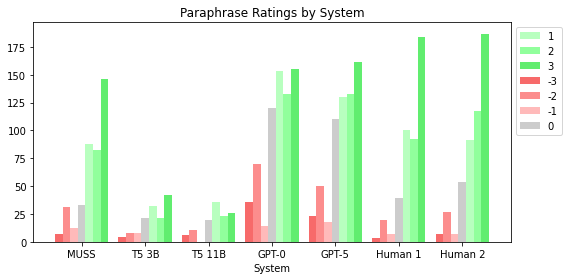

In [31]:
ratings_by_edit_type(data, 'paraphrase')
# ratings_by_edit_type(data, 'split')
# ratings_by_edit_type(data, 'reorder')
# ratings_by_edit_type(data, 'structure')

IndexError: index 4 is out of bounds for axis 1 with size 4

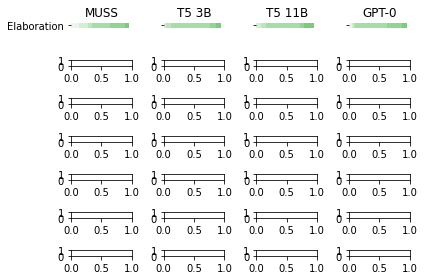

In [32]:
edit_ratings_barh(data, old_formatting=True)

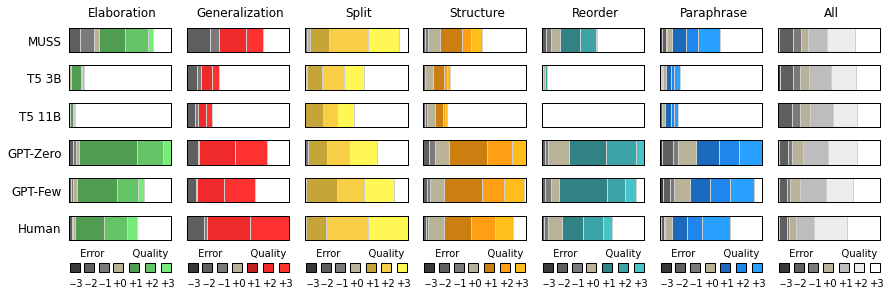

In [ ]:
edit_ratings_barh(data) # include_all=False

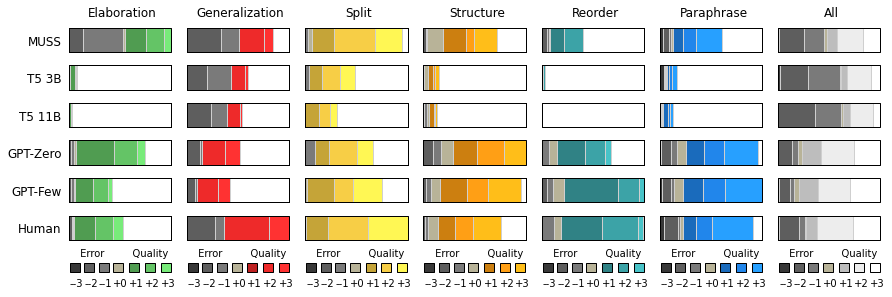

In [ ]:
edit_ratings_barh(data, size_weighted=True)

In [ ]:
# Prints a table quality edits
for family in ['elaboration', 'generalization', 'split', 'structure', 'reorder', 'paraphrase']:
    ratings = get_ratings_by_edit_type(data, family)
    al = f'{family} & '
    for system in [s for s in all_system_labels if s in ratings.keys() and '2' not in s]:
        total = sum([x if type(x) is int else sum(x.values()) for x in list(ratings[system].values())])
        nl = ""
        for i in range(3):
            nl += (f'{round(ratings[system]["error"][i] / total, 2)*100:.0f} & ')
        nl += (f'{round(ratings[system]["trivial"] / total, 2)*100:.0f} & ')
        for i in range(3):
            nl += (f'{round(ratings[system]["quality"][i] / total, 2)*100:.0f} & ')
        al += nl
    al = ' & ' + al[:-2].capitalize() + '\\tabularnewline'
    print(al)

 & Elaboration & 0 & 13 & 16 & 6 & 32 & 27 & 6 & 0 & 0 & 3 & 10 & 68 & 10 & 10 & 0 & 0 & 8 & 8 & 58 & 8 & 17 & 0 & 4 & 3 & 3 & 56 & 26 & 8 & 0 & 3 & 3 & 6 & 53 & 29 & 7 & 0 & 5 & 2 & 2 & 42 & 29 & 20 \tabularnewline
 & Generalization & 0 & 30 & 11 & 0 & 0 & 35 & 23 & 0 & 30 & 15 & 0 & 0 & 34 & 21 & 0 & 32 & 14 & 0 & 0 & 32 & 23 & 0 & 14 & 2 & 0 & 0 & 45 & 39 & 0 & 13 & 1 & 0 & 0 & 40 & 45 & 0 & 16 & 3 & 0 & 0 & 43 & 38 \tabularnewline
 & Split & 0 & 0 & 2 & 4 & 20 & 42 & 33 & 0 & 1 & 1 & 0 & 26 & 37 & 34 & 0 & 0 & 0 & 0 & 36 & 29 & 36 & 0 & 0 & 3 & 0 & 27 & 31 & 38 & 0 & 0 & 0 & 1 & 35 & 30 & 34 & 0 & 0 & 0 & 1 & 21 & 39 & 39 \tabularnewline
 & Structure & 0 & 3 & 4 & 22 & 37 & 16 & 18 & 0 & 4 & 2 & 29 & 44 & 9 & 11 & 0 & 5 & 10 & 32 & 34 & 10 & 10 & 0 & 6 & 5 & 14 & 37 & 25 & 14 & 0 & 3 & 3 & 14 & 38 & 22 & 20 & 0 & 2 & 2 & 16 & 33 & 30 & 16 \tabularnewline


ZeroDivisionError: division by zero

In [ ]:
# - Average quality edit (or log-size * average) rating for these modification types
#     - Content, Syntax, Lexical
#     - Elaboration, Generalization, Paraphrase, Structure, Reorder, Split
# - Average error edit for Content, Syntax, Lexical i guess?
# - Overlap the annotator’s decision for each system

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json', '../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/b

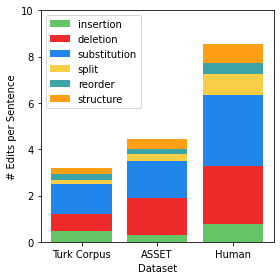

In [ ]:
all_data = load_data('../annotated', preprocess=True)
edit_type_by_system(all_data, humans=True, normalized=True)

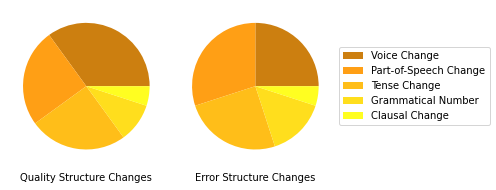

In [ ]:
subtypes = [
    'Voice Change',
    'Part-of-Speech Change',
    'Tense Change',
    'Grammatical Number',
    'Clausal Change'
]

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
quality = np.array([35, 25, 25, 10, 5])
error = np.array([25, 30, 25, 15, 5])

color = color_mapping['structure']
scalar = [0.8, 1, 1.2, 1.4, 1.6]
colors = []
for s in scalar:
    colors += [colorscale(color, s)]

axs[0].pie(quality, colors=colors, labels=subtypes, labeldistance=None)
axs[1].pie(error, colors=colors, labels=subtypes, labeldistance=None)

axs[0].set_xlabel('Quality Structure Changes')
axs[1].set_xlabel('Error Structure Changes')
axs[1].legend(subtypes, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.suptitle("Manual Breakdown of Structure Changes")

out_filename = "img/structure-breakdown.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show() 

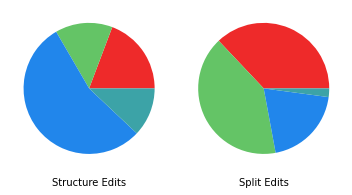

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

labels, values = zip(*count_dataset_composite_edits(data, 'structure').items())
axs[0].pie(values, colors=[color_mapping[l] for l in labels], labels=labels, labeldistance=None)

labels, values = zip(*count_dataset_composite_edits(data, 'split').items())
axs[1].pie(values, colors=[color_mapping[l] for l in labels], labels=labels, labeldistance=None)

axs[0].set_xlabel('Structure Edits')
axs[1].set_xlabel('Split Edits')
# plt.suptitle("Child Edits of Composite Edits")

out_filename = "img/composite-breakdown.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show() 